В этой части проекта вам нужно написать несколько SQL-запросов в Jupyter Notebook. Эти задания проверят вручную, и вы получите комментарии к составленным запросам. 

Необходимые данные находятся в таблицах схемы `stackoverflow`. Не забудьте подключиться к базе с помощью SQLAlchemy. Вспомните инструкцию из урока 11 «Когортный анализ. Представление результатов» в теме 2 «Установка и настройка базы данных и клиента базы данных».. Пример кода для подключения к базе и выгрузки результатов вы найдёте и в этой тетрадке. 

Некоторые задания включают дополнительные вопросы — не пропустите их. На часть вопросов можно ответить текстом, а для некоторых понадобится визуализация. Помните, что результат запроса можно выгрузить в датафрейм. 

Чтобы ожидаемый результат было легче представить, мы добавили к каждому заданию небольшой фрагмент итоговой таблицы. В запросах вы можете использовать любые подходящие названия полей.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine 
import seaborn as sns
import matplotlib.pyplot as plt

### Конфигурация для подключения к базе данных `data-analyst-advanced-sql`
Эта база данных содержит схему `stackoverflow`, с которой вы будете работать в проекте

In [2]:
db_config = {
    'user': 'praktikum_student', # имя пользователя
    'pwd': 'Sdf4$2;d-d30pp', # пароль
    'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
    'port': 6432, # порт подключения
    'db': 'data-analyst-advanced-sql' # название базы данных
}  

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

Создание подключения

In [3]:
engine = create_engine(connection_string) 

Пример запроса к базе данных

`sample_df` является pandas-датафреймом.

In [4]:
query = '''
SELECT *
FROM stackoverflow.users
LIMIT 10;
'''

sample_df = pd.read_sql_query(query, con=engine) 

In [5]:
sample_df

,id,creation_date,display_name,last_access_date,location,reputation,views
0,1,2008-07-31 14:22:31,Jeff Atwood,2018-08-29 02:34:23,"El Cerrito, CA",44300,408587
1,2,2008-07-31 14:22:31,Geoff Dalgas,2018-08-23 17:31:56,"Corvallis, OR",3491,23966
2,3,2008-07-31 14:22:31,Jarrod Dixon,2018-08-30 20:56:24,"Raleigh, NC, United States",13418,24396
3,4,2008-07-31 14:22:31,Joel Spolsky,2018-08-14 22:18:15,"New York, NY",28768,73755
4,5,2008-07-31 14:22:31,Jon Galloway,2018-08-29 16:48:36,"San Diego, CA",39172,11700
5,8,2008-07-31 21:33:24,Eggs McLaren,2018-04-09 02:04:56,None,942,6372
6,9,2008-07-31 21:35:27,Kevin Dente,2018-08-30 18:18:03,"Oakland, CA",14337,4949
7,11,2008-08-01 00:59:11,Anonymous User,2008-08-01 00:59:11,None,1890,2123
8,13,2008-08-01 04:18:05,Chris Jester-Young,2018-08-30 02:47:23,"Raleigh, NC, United States",177138,35414
9,17,2008-08-01 12:02:22,Nick Berardi,2018-01-22 01:35:38,"Issaquah, WA",44443,4786


# Задание 1

Выведите общую сумму просмотров постов за каждый месяц 2008 года. Если данных за какой-либо месяц в базе нет, такой месяц можно пропустить. Результат отсортируйте по убыванию общего количества просмотров.

| month_date  | total_views |
| ------------- | ------------- |
| 2008-09-01  | 452928568  |
| 2008-10-01  | 365400138  |
| ...         | ... |

In [6]:
# напишите запрос
query = '''
SELECT DATE_TRUNC('month', creation_date)::date AS month,
       SUM(views_count) AS total_views
FROM stackoverflow.posts
WHERE EXTRACT(YEAR FROM creation_date) = 2008
GROUP BY month
ORDER BY total_views DESC;
'''

# выполните запрос
task1_df = pd.read_sql_query(query, con=engine) 
task1_df

,month,total_views
0,2008-09-01,452928568
1,2008-10-01,365400138
2,2008-11-01,221759651
3,2008-12-01,197792841
4,2008-08-01,131367083
5,2008-07-01,669895


**ОТВЕТ**

Да, данные существенно отличаются из месяца в месяц. Самые пиковые месяца пришлись на осень, самые худшие на лето и декабрь. 

Отличия могут быть связаны с тем, что сервис stack overflow как раз начал свое существование в июле-августе 2008 года, соотвественно он только начинал набирать популярность. а небольшое кол-во просмотров в декабре, можно предположить, что рождество и новый год близился и многим было не особо до программирвоания)

# Задание 2

Выведите имена самых активных пользователей, которые в первый месяц после регистрации (включая день регистрации) дали больше 100 ответов. Вопросы, которые задавали пользователи, не учитывайте. Для каждого имени пользователя выведите количество уникальных значений `user_id`. Отсортируйте результат по полю с именами в лексикографическом порядке.

| display_name | count |
| ------------ | ----- |
| 1800 INFORMATION | 1 |
| Adam Bellaire | 1 |
| Adam Davis | 1 |
| ... | ... |

In [7]:
# напишите запрос
query2 = '''
SELECT DISTINCT u.display_name,
        COUNT(DISTINCT p.user_id)
FROM stackoverflow.users u
JOIN stackoverflow.posts p ON u.id = p.user_id
WHERE p.creation_date BETWEEN u.creation_date AND u.creation_date + INTERVAL '1 month'
      AND p.post_type_id = (SELECT id FROM stackoverflow.post_types WHERE type = 'Answer')
GROUP BY u.display_name
HAVING COUNT(*) > 100
ORDER BY u.display_name;
'''

# выполните запрос
task2_df = pd.read_sql_query(query2, con=engine) 
task2_df.head(20)

,display_name,count
0,1800 INFORMATION,1
1,Adam Bellaire,1
2,Adam Davis,1
3,Adam Liss,1
4,Alan,8
5,Amy B,1
6,Ben Hoffstein,1
7,Brian,15
8,Cade Roux,1
9,CesarB,1


**ОТВЕТ**

Одиночные ответы: мы видим,что много пользователей дали всего по одному ответу. Это странный, так как редко кто-то так активно участвует в сообществе, чтобы дать всего один ответ.

И наоборот есть пользователи с большим количеством ответов: (например, пользователь "Chris" с 29 ответами). Это уже тоже что-то интересненькое в какой-то степени.

# Задание 3

Выведите количество постов за 2008 год по месяцам. Отберите посты от пользователей, которые зарегистрировались в сентябре 2008 года и сделали хотя бы один пост в декабре того же года. Отсортируйте таблицу по значению месяца по убыванию.

| month | count |
| ------|------ |
| 2008-12-01 | 17641 |
| 2008-11-01 | 18294 |
| ... | ... |

In [8]:
# напишите запрос
query3 = '''
WITH september_users AS (
    SELECT DISTINCT u.id
    FROM stackoverflow.users u
    WHERE EXTRACT(YEAR FROM u.creation_date) = 2008
      AND EXTRACT(MONTH FROM u.creation_date) = 9
),
december_posts AS (
    SELECT DISTINCT p.user_id
    FROM stackoverflow.posts p
    WHERE EXTRACT(YEAR FROM p.creation_date) = 2008
      AND EXTRACT(MONTH FROM p.creation_date) = 12
)
SELECT DATE_TRUNC('month', p.creation_date) AS month,
       COUNT(p.id) AS post_count
FROM stackoverflow.posts p
JOIN september_users su ON p.user_id = su.id
JOIN december_posts dp ON p.user_id = dp.user_id
WHERE EXTRACT(YEAR FROM p.creation_date) = 2008
GROUP BY month
ORDER BY month DESC;
'''

# выполните запрос
task3_df = pd.read_sql_query(query3, con=engine) 
task3_df

,month,post_count
0,2008-12-01,17641
1,2008-11-01,18294
2,2008-10-01,27171
3,2008-09-01,24870
4,2008-08-01,32


**ОТВЕТ**

Да, есть аномалия - в августе, как по мне, то этот месяц вообще не должен был здесь оказаться, так как по заданию мы искали тех пользователей, кто зарегистрировался в сентябре и сделал хотя бы 1 пост в декабре. 

Полагаю это может быть связано опять же с тем, что в августе сервис только начал работать и возможно там прозиошли какието сбои в введении и распределнии БД

# Задание 4

Используя данные о постах, выведите несколько полей:

- идентификатор пользователя, который написал пост;
- дата создания поста;
- количество просмотров у текущего поста;
- сумму просмотров постов автора с накоплением.

Данные в таблице должны быть отсортированы по возрастанию идентификаторов пользователей, а данные об одном и том же пользователе — по возрастанию даты создания поста.

| user_id | creation_date | views_count | cumulative_count |
| ------ | -------------- | ----------- | ---------------- |
| 1 | 2008-07-31 23:41:00  | 480476   | 480476  |
| 1 | 2008-07-31 23:55:38  | 136033 | 616509  | 
| 1 | 2008-07-31 23:56:41  | 0 |  616509  |
| ... | ... | ... | ... |
| 2 | 2008-07-31 23:56:41 | 79087  | 79087 |
| 2 | 2008-08-01 05:09:56 | 65443 | 144530 |
| ... | ...  | ...  | ...  |

In [9]:
# напишите запрос
query4 = '''
SELECT user_id,
       creation_date,
       views_count,
       SUM(views_count) OVER(PARTITION BY user_id ORDER BY creation_date) AS cumulative_count
FROM stackoverflow.posts
ORDER BY user_id, creation_date

'''

# выполните запрос
task4_df = pd.read_sql_query(query4, con=engine) 
task4_df

,user_id,creation_date,views_count,cumulative_count
0,1,2008-07-31 23:41:00,480476,480476
1,1,2008-07-31 23:55:38,136033,616509
2,1,2008-07-31 23:56:41,0,616509
3,1,2008-08-04 02:45:08,0,616509
4,1,2008-08-04 04:31:03,0,616509
...,...,...,...,...
243791,5696608,2008-12-23 16:00:37,0,2804
243792,5696608,2008-12-23 17:35:09,0,2804
243793,5696608,2008-12-24 01:02:48,0,2804
243794,5696608,2008-12-30 14:34:45,0,2804


# Задание 5

Найдите среднее количество постов пользователей в день за август 2008 года. Отберите данные о пользователях, которые опубликовали больше 120 постов за август. Дни без публикаций не учитывайте. 

Отсортируйте результат по возрастанию среднего количества постов. Значения можно не округлять.

| user_id | avg_daily |
| ------- | --------- |
| 116     | 4.777778  |
| 234     | 5.208333  |
| ...     | ... |

In [10]:
# напишите запрос
query5 = '''
WITH top_users AS (
    SELECT user_id
    FROM stackoverflow.posts
    WHERE creation_date::date BETWEEN '2008-08-01' AND '2008-08-31'
    GROUP BY user_id
    HAVING COUNT(id) > 120
),

per_day AS (
    SELECT user_id,
            EXTRACT(DAY FROM creation_date::date) AS day,
            COUNT(id) AS post_count
    FROM stackoverflow.posts
    WHERE creation_date::date BETWEEN '2008-08-01' AND '2008-08-31' AND
            user_id IN (SELECT user_id FROM top_users)
    GROUP BY user_id, day
    ORDER BY day
)

SELECT user_id,
        AVG(post_count)
FROM per_day
GROUP BY user_id
ORDER BY AVG(post_count)

'''

# выполните запрос
task5_df = pd.read_sql_query(query5, con=engine) 
task5_df

,user_id,avg
0,116,4.777778
1,234,5.208333
2,91,5.681818
3,905,7.000000
4,383,7.277778


# Задание 6

Сколько в среднем дней в период с 1 по 7 декабря 2008 года пользователи взаимодействовали с платформой? Для каждого пользователя отберите дни, в которые он или она опубликовали хотя бы один пост. Нужно получить одно целое число — не забудьте округлить результат. 

| result |
| -----  |
| <целое число> |

In [11]:
# напишите запрос
query6 = '''
WITH up_counts AS (
    SELECT user_id,
           COUNT(DISTINCT EXTRACT(DAY FROM creation_date::date)) AS post_days
    FROM stackoverflow.posts
    WHERE creation_date::date BETWEEN '2008-12-01' AND '2008-12-07'
    GROUP BY user_id
)

SELECT ROUND(AVG(post_days), 2) AS result
FROM up_counts;

'''

# выполните запрос
task6_df = pd.read_sql_query(query6, con=engine) 
task6_df

,result
0,1.77


**ОТВЕТ**

Мы видим, что в среднем все пользователи, что сделали хотя бы 1 пост за первую неделю декабря 2008 года, пробыли на платформе за тот же период в среднем 1.77 дня

# Задание 7

Выведите историю активности каждого пользователя в таком виде: идентификатор пользователя, дата публикации поста. Отсортируйте вывод по возрастанию идентификаторов пользователей, а для каждого пользователя — по возрастанию даты публикации.

Добавьте в таблицу новое поле: для каждого поста в нём будет указано название месяца предпоследней публикации пользователя относительно текущей. Если такой публикации нет, укажите `NULL`.  Python автоматически поменяет `NULL` на `None`, но дополнительно преобразовывать значения `None` вам не нужно.

Посмотрите внимательно на образец таблицы: для первых двух постов предпоследней публикации нет, но, начиная с третьего поста, в новое поле входит нужный месяц. Для следующего пользователя в первые две записи поля `second_last_month` тоже войдёт `NULL`.

| user_id | creation_date | second_last_month |
| ------- | ------------- | ----------------- |
| 1       | 2008-07-31 23:41:00 | None |
| 1       | 2008-07-31 23:55:38 | None |
| 1       | 2008-07-31 23:56:41 | July |
| 1       | 2008-08-04 02:45:08 | July |
| 1       | 2008-08-04 04:31:03 | July |
| 1       | 2008-08-04 08:04:42 | August |
| ... | ... | ... |

In [12]:
# напишите запрос
query7 = '''
WITH UserActivity AS (
    SELECT
        user_id,
        creation_date,
        LAG(EXTRACT(MONTH FROM creation_date), 2) OVER (PARTITION BY user_id ORDER BY creation_date) AS second_last_month
    FROM stackoverflow.posts
)

SELECT
    user_id,
    creation_date,
    CASE
        WHEN second_last_month IS NULL THEN NULL
        ELSE TO_CHAR(DATE_TRUNC('month', DATE '2008-01-01' + INTERVAL '1 month' * (second_last_month - 1)), 'Month')
    END AS second_last_month
FROM UserActivity
ORDER BY user_id, creation_date;

'''

# выполните запрос
task7_df = pd.read_sql_query(query7, con=engine) 
task7_df

,user_id,creation_date,second_last_month
0,1,2008-07-31 23:41:00,None
1,1,2008-07-31 23:55:38,None
2,1,2008-07-31 23:56:41,July
3,1,2008-08-04 02:45:08,July
4,1,2008-08-04 04:31:03,July
...,...,...,...
243791,5696608,2008-12-23 16:00:37,December
243792,5696608,2008-12-23 17:35:09,December
243793,5696608,2008-12-24 01:02:48,December
243794,5696608,2008-12-30 14:34:45,December


# Задание 8

Рассчитайте аналог Retention Rate по месяцам для пользователей StackOverflow. Объедините пользователей в когорты по месяцу их первого поста. Возвращение определяйте по наличию поста в текущем месяце. 

| cohort_dt | session_date | users_cnt | cohort_users_cnt | retention_rate |
| --- | --- | --- | --- | --- |
| 2008-07-01 00:00:00 | 2008-07-01 00:00:00 | 3 | 3 | 100 |
| 2008-07-01 00:00:00 | 2008-08-01 00:00:00 | 2 | 3 | 66,67 |
| 2008-07-01 00:00:00 | 2008-09-01 00:00:00 | 1 | 3 | 33,33 |
| 2008-07-01 00:00:00 | 2008-10-01 00:00:00 | 2 | 3 | 66,67 |
| 2008-07-01 00:00:00 | 2008-11-01 00:00:00 | 1 | 3 | 33,33 |
| 2008-07-01 00:00:00 | 2008-12-01 00:00:00 | 2 | 3 | 66,67 |
| 2008-08-01 00:00:00 | 2008-08-01 00:00:00 | 2151 | 2151 | 100 |
| ... | ... | ... | ... | ... |

In [13]:
# напишите запрос
query8 = '''
WITH profile AS (
    SELECT
        user_id,
        DATE_TRUNC('month', MIN(creation_date)) AS cohort_month
    FROM stackoverflow.posts
    GROUP BY user_id
),
sessions AS (
    SELECT
        user_id,
        DATE_TRUNC('month', creation_date) AS session_month
    FROM stackoverflow.posts
    GROUP BY user_id, DATE_TRUNC('month', creation_date)
),
cohort_counts AS (
    SELECT
        cohort_month,
        COUNT(user_id) AS cohort_users_count
    FROM profile
    GROUP BY cohort_month
)
SELECT
    p.cohort_month,
    s.session_month,
    COUNT(s.user_id) AS users_count,
    cc.cohort_users_count,
    ROUND(COUNT(s.user_id) * 100.0 / cc.cohort_users_count, 2) AS retention_rate
FROM sessions s
JOIN profile p ON s.user_id = p.user_id
JOIN cohort_counts cc ON p.cohort_month = cc.cohort_month
GROUP BY p.cohort_month, s.session_month, cc.cohort_users_count
ORDER BY p.cohort_month, s.session_month;

'''

# выполните запрос
task8_df = pd.read_sql_query(query8, con=engine) 
task8_df

,cohort_month,session_month,users_count,cohort_users_count,retention_rate
0,2008-07-01,2008-07-01,3,3,100.00
1,2008-07-01,2008-08-01,2,3,66.67
2,2008-07-01,2008-09-01,1,3,33.33
3,2008-07-01,2008-10-01,2,3,66.67
4,2008-07-01,2008-11-01,1,3,33.33
5,2008-07-01,2008-12-01,2,3,66.67
6,2008-08-01,2008-08-01,2151,2151,100.00
7,2008-08-01,2008-09-01,1571,2151,73.04
8,2008-08-01,2008-10-01,1275,2151,59.27
9,2008-08-01,2008-11-01,1050,2151,48.81


Постройте тепловую карту Retention Rate. Какие аномалии или другие необычные явления удалось выявить? Сформулируйте гипотезы о возможных причинах.

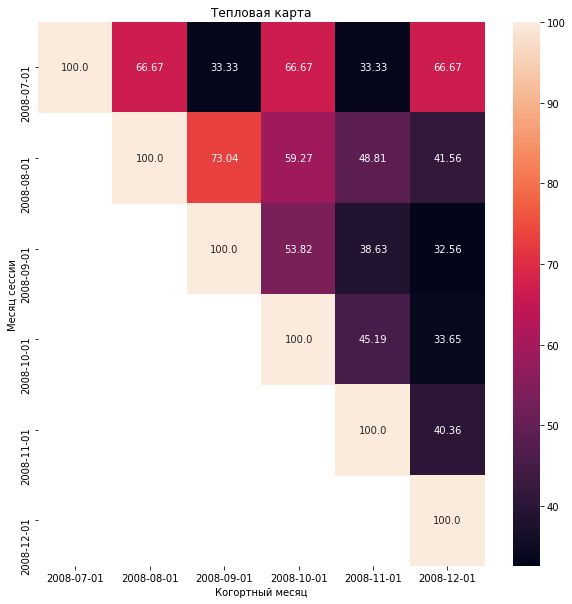

In [14]:
# постройте тепловую карту Retention Rate
# создаём сводную таблицу с результатами
retention = task8_df.pivot('cohort_month', 'session_month', 'retention_rate')
retention.index = [str(x)[0:10] for x in retention.index]
retention.columns = [str(x)[0:10] for x in retention.columns]

# строим хитмэп
plt.figure(figsize=(10, 10)) # задаём размер графика
sns.heatmap(retention, # датафрейм с данными
            annot=True, # добавляем подписи
            fmt='') # задаём исходный формат
plt.title('Тепловая карта') # название графика
plt.xlabel('Когортный месяц')  # Подпись оси x
plt.ylabel('Месяц сессии')  # Подпись оси y

plt.show() 


По тепловой карте мы видим, что удержание пользователей убывает со временем. Во всех когортах, кроме той, где пользователи зарегистрирвоались в июле. Например, удержание для пользователей из когорты августа 2008 года начинается с 100% в августе, а затем снижается в последующие месяцы. Это говорит о том, что с течением времени часть пользователей уже подзабивают на платформу.

Но при этом есть аномальные значения по июльской когорте. В гугле написан, что сервис заработал в августе 2008 года в целом, и как в заданиях ранее уже отмечалось, возможно с этой временной несостыковкой и связана эта аномалия. может в июле на сервис была "запущена" тестовая группа пользователей, которые каждые два месяца проявляли активность, так можно было бы объяснить такую чехарду в ретенш 66,6 - 33,33 - 66,6 - 33,3 и так далее.

Плюс мы видим, что пик актвиности пришелся как раз на август 2008 года. Самый большой показатель ретеншена. И при этом видим, как к ноябрю колво активных пользователей снижается во втором месяце их пребывания с пиковых 73,04 до 40,36 к декабрю месяце. Такая же зависимость наблюдается во всех когортах (кроме июльской) что к 3ему и 4му месяцу активность везде практически пропорционально падает..

# Задание 9


На сколько процентов менялось количество постов ежемесячно с 1 сентября по 31 декабря 2008 года? Отобразите таблицу со следующими полями:

- номер месяца;
- количество постов за месяц;
- процент, который показывает, насколько изменилось количество постов в текущем месяце по сравнению с предыдущим.

Если постов стало меньше, значение процента должно быть отрицательным, если больше — положительным. Округлите значение процента до двух знаков после запятой.

Напомним, что при делении одного целого числа на другое в PostgreSQL в результате получится целое число, округлённое до ближайшего целого вниз. Чтобы этого избежать, переведите делимое в тип `numeric`.

| creation_month | posts_count | percentage |
| -------------- | ----------- | ---------- |
| 9 | 70731 | Nan |
| 10 | 63102 | -10.33 |
| ... | ... | ... |

In [16]:
# напишите запрос
query9 = '''
WITH monthly_posts AS (
    SELECT
        DATE_TRUNC('month', creation_date) AS month,
        COUNT(*) AS post_count
    FROM stackoverflow.posts
    WHERE creation_date::date BETWEEN '2008-09-01' AND '2008-12-31'
    GROUP BY month
)

SELECT
    EXTRACT(MONTH FROM month) AS month_number,
    post_count,
    ROUND(
        (post_count - LAG(post_count) OVER (ORDER BY month)) * 100.0 / LAG(post_count) OVER (ORDER BY month),
        2
    ) AS percent_change
FROM monthly_posts
ORDER BY month_number;

'''

# выполните запрос
task9_df = pd.read_sql_query(query9, con=engine) 
task9_df

,month_number,post_count,percent_change
0,9.0,70371,NaN
1,10.0,63102,-10.33
2,11.0,46975,-25.56
3,12.0,44592,-5.07


Постройте круговую диаграмму с количеством постов по месяцам.

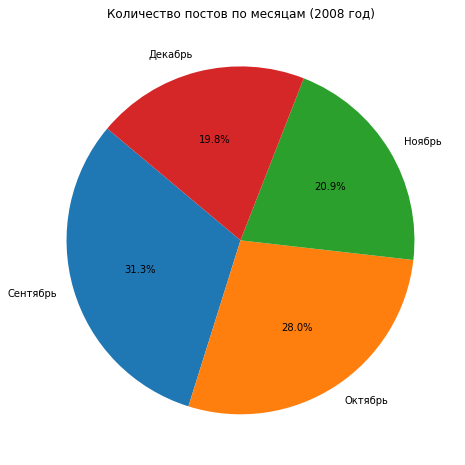

In [17]:
# постройте круговую диаграмму с количеством постов по месяцам
months = ["Сентябрь", "Октябрь", "Ноябрь", "Декабрь"]
post_counts = task9_df['post_count']

plt.figure(figsize=(8, 8))
plt.pie(post_counts, labels=months, autopct='%1.1f%%', startangle=140)
plt.title('Количество постов по месяцам (2008 год)')

plt.show()


# Задание 10

Выгрузите данные активности пользователя, который опубликовал больше всего постов за всё время. Выведите данные за октябрь 2008 года в таком виде:

- номер недели;
- дата и время последнего поста, опубликованного на этой неделе.

| week_creation | creation_date |
| ------------- | ------------- |
| 40 | 2008-10-05 09:00:58 |
| 41 | 2008-10-12 21:22:23 |
| ... | ... |

In [18]:
# напишите запрос
query10 = '''
WITH top_user AS (
    SELECT user_id
    FROM stackoverflow.posts
    GROUP BY user_id
    ORDER BY COUNT(*) DESC
    LIMIT 1
), 
user_posts AS (
    SELECT
        p.user_id,
        p.creation_date,
        EXTRACT(WEEK FROM p.creation_date) AS week_number,
        ROW_NUMBER() OVER (PARTITION BY p.user_id, EXTRACT(WEEK FROM p.creation_date) ORDER BY p.creation_date DESC) AS post_rank
    FROM stackoverflow.posts p
    JOIN top_user u ON p.user_id = u.user_id
    WHERE EXTRACT(YEAR FROM p.creation_date) = 2008 AND EXTRACT(MONTH FROM p.creation_date) = 10
)

SELECT
    week_number AS week_creation,
    MAX(creation_date) AS creation_date
FROM user_posts
WHERE post_rank = 1
GROUP BY week_number
ORDER BY week_number;
'''

# выполните запрос
task10_df = pd.read_sql_query(query10, con=engine) 
task10_df

,week_creation,creation_date
0,40.0,2008-10-05 09:00:58
1,41.0,2008-10-12 21:22:23
2,42.0,2008-10-19 06:49:30
3,43.0,2008-10-26 21:44:36
4,44.0,2008-10-31 22:16:01
